# Test inference using previosly trained and deployed model


## Import Libraries

In [1]:
import torch
import base64
import json
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from azure.ai.ml import MLClient, Input
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment, Model, CodeConfiguration, OnlineRequestSettings
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential
from azure.core.exceptions import ResourceNotFoundError
from helper import ConvertToMultiChannelBasedOnBratsClassesd
from monai.apps import DecathlonDataset
from monai.data import DataLoader, Dataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd, Spacingd, NormalizeIntensityd
from monai.visualize.utils import blend_images


## Define constants

In [2]:
# Deployment
online_endpoint_name = 'SRN-endpoint-demo1234'
registered_model_name = 'best-model'
deployment_name = 'blue'
inference_env_name = 'inference-env'
request_file_name = 'request.json'

## Create ML Client

In [3]:
credential = DefaultAzureCredential()

ml_client = MLClient.from_config(credential=credential)

2023-04-25 00:08:44,877 - No environment configuration found.
2023-04-25 00:08:44,878 - ManagedIdentityCredential will use Azure ML managed identity


Found the config file in: ./config.json


## Connect to already deployed Endpoint

In [5]:
try:
    endpoint = ml_client.online_endpoints.get(online_endpoint_name)
    print("Found existing endpoint.")
except ResourceNotFoundError:
    print("Didnt find workign endpoint: {online_endpoint_name} ...")
    quit()

2023-04-25 00:09:09,096 - DefaultAzureCredential acquired a token from ManagedIdentityCredential
Found existing endpoint.


## Verify Endpoint traffic and inference url

In [6]:
# existing traffic details
print(endpoint.traffic)
# Get the scoring URI
print(endpoint.scoring_uri)

{'blue': 0}
https://srn-endpoint-demo1234.westeurope.inference.ml.azure.com/score


## Reset traffic to Max

In [7]:
# blue deployment takes 100 traffic
endpoint.traffic = {deployment_name: 100}
ml_client.online_endpoints.begin_create_or_update(endpoint)

2023-04-25 00:09:28,876 - DefaultAzureCredential acquired a token from ManagedIdentityCredential
2023-04-25 00:09:28,972 - Readonly attribute principal_id will be ignored in class <class 'azure.ai.ml._restclient.v2022_05_01.models._models_py3.ManagedServiceIdentity'>
2023-04-25 00:09:28,973 - Readonly attribute tenant_id will be ignored in class <class 'azure.ai.ml._restclient.v2022_05_01.models._models_py3.ManagedServiceIdentity'>


## Define validation samples

In [8]:
# Visualization and validation sample
sample_image = '../samples/BraTS2021_00402_flair.nii.gz' 
sample_image_t1 = '../samples/BraTS2021_00402_t1.nii.gz'
sample_image_t1ce = '../samples/BraTS2021_00402_t1ce.nii.gz'
sample_image_t2 = '../samples/BraTS2021_00402_t2.nii.gz'
sample_label = '../samples/BraTS2021_00402_seg.nii.gz'

## Encode validation images and create .json request file

In [9]:
# Encode input images for JSON request file
with open(sample_image, "rb") as image_file:
    flair_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t1, "rb") as image_file:
    t1_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t1ce, "rb") as image_file:
    t1ce_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t2, "rb") as image_file:
    t2_encoded = base64.b64encode(image_file.read()).decode('utf-8')

request_data = {
    "data": [{"flair": flair_encoded, "t1": t1_encoded, 
              "t1ce": t1ce_encoded, "t2": t2_encoded
             }]
}

# Write the JSON request data to a file
with open(request_file_name, "w") as outfile:
    json.dump(request_data, outfile)

## Send the request and get the responce from Endpoint

In [10]:
response = ml_client.online_endpoints.invoke(
    endpoint_name= online_endpoint_name,
    deployment_name= deployment_name,
    request_timeout_ms=90000,
    request_file=request_file_name,
)

## Convert the responce to numpy array for visualization

In [11]:
# convert response to numpy array with dimensions channel, height, width, slice
json_response = json.loads(response)
pred_vol = np.array(json_response)

## Convert labels and to inspect inference results like in the first notebook

In [12]:
val_transform = Compose(
[
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    EnsureTyped(keys=["image", "label"]),
    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

data_list = [{'image': sample_image, 'label': sample_label}]
val_ds = Dataset(data=data_list, transform=val_transform)

img_vol = val_ds[0]["image"].numpy()
seg_vol = val_ds[0]["label"].numpy()

## Use ipywidgets plugin to visualize original and predicted images

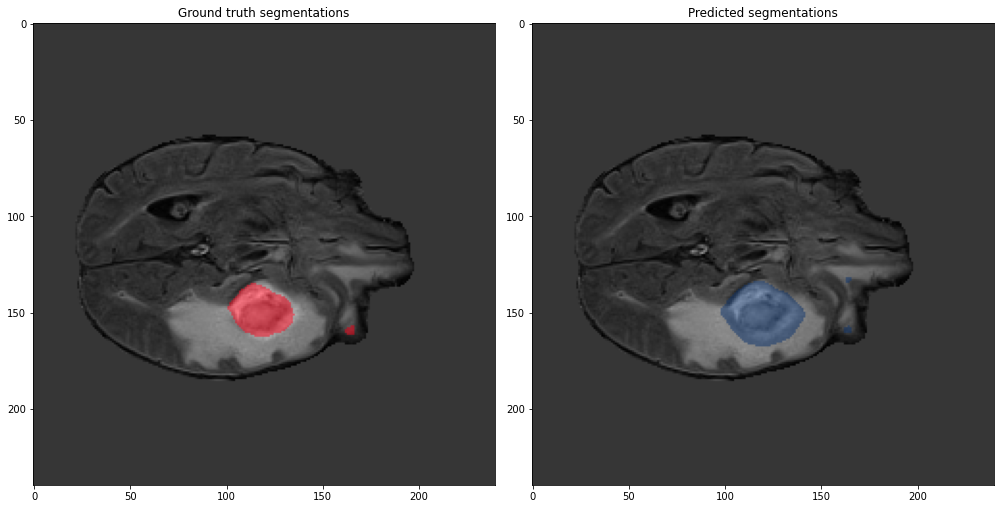

In [13]:
def show_slice(slice_index=60):

    img = np.expand_dims(img_vol[0,:,:,slice_index], 0) # images
    true_seg = np.expand_dims(seg_vol[0,:,:,slice_index], 0) # annotated ground truth labels
    pred_seg = np.expand_dims(pred_vol[0,:,:,slice_index], 0)  # predicted labels
    
    blend = blend_images(img, true_seg, cmap='hsv')
    over_true = np.transpose(blend, (1,2,0))
    blend = blend_images(img, pred_seg, cmap='Blues')
    over_pred = np.transpose(blend, (1,2,0))
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 7))

    ax1.imshow(over_true)
    ax1.set_title('Ground truth segmentations')
    ax2.imshow(over_pred)
    ax2.set_title('Predicted segmentations')
    
    plt.tight_layout()
    plt.show()

# Use the interact function to create a slider for the slice index
_ = interact(show_slice, slice_index=(0, img_vol.shape[-1]-1))